In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
pd.options.mode.chained_assignment = None

In [6]:
df0 = pd.read_csv('prices_round_2_day_-1.csv', delimiter = ';') # Day -1
df1 = pd.read_csv('prices_round_2_day_0.csv', delimiter = ';') # Day 0
df2 = pd.read_csv('prices_round_2_day_1.csv', delimiter = ';') # Day 1

# We do this so we can combine 3 days and make one big graph
df1['timestamp'] = df1['timestamp'] + 1000000
df2['timestamp'] = df2['timestamp'] + 2000000
df_concat = pd.concat([df0, df1, df2], ignore_index=True)


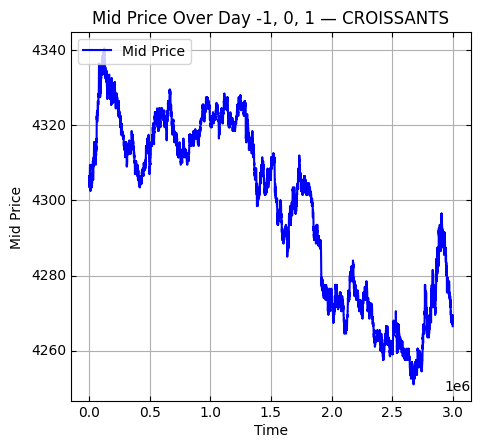

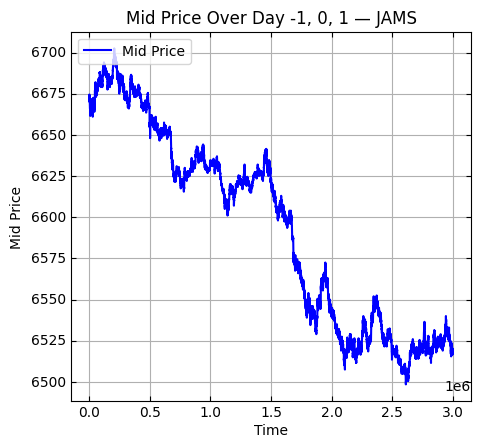

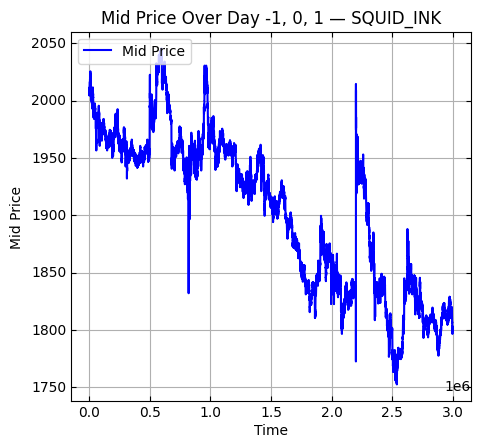

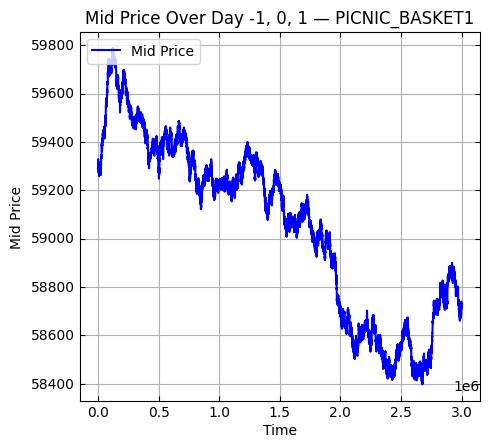

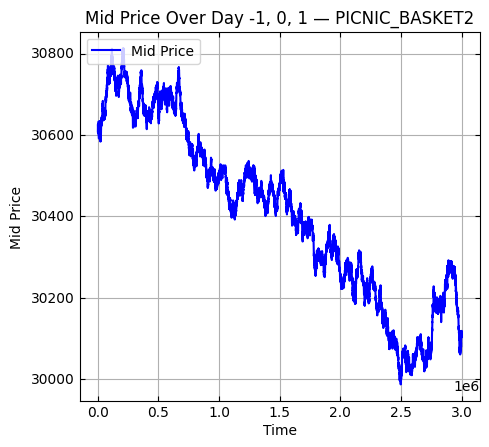

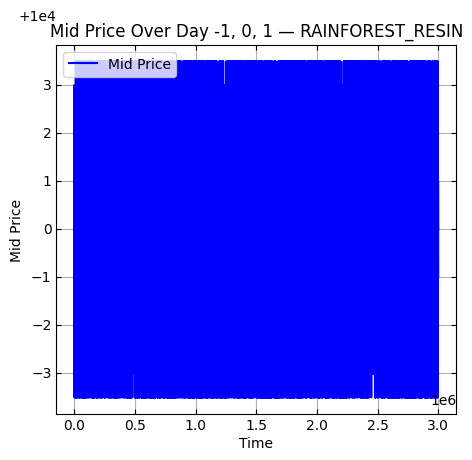

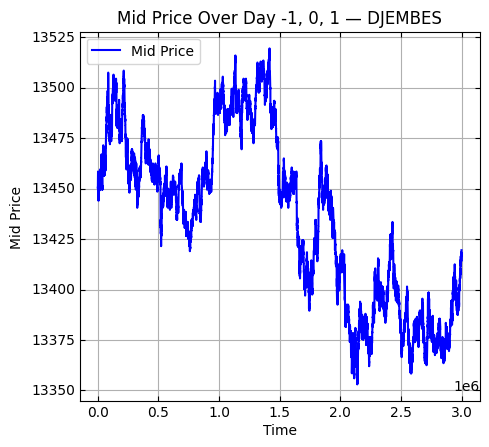

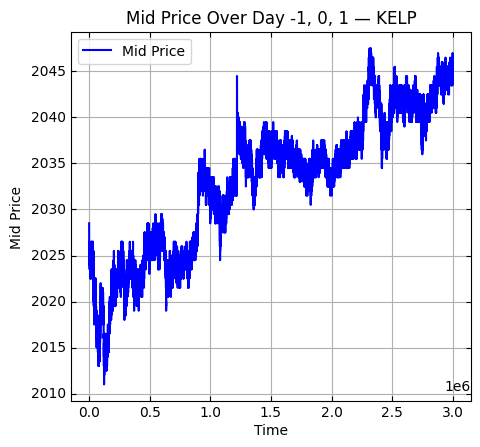

In [12]:
# Plots every product price over the past three days
products = df_concat['product'].unique()

for product in products:
    product_data = df_concat[df_concat['product'] == product]

    # Create host subplot
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    # Plot mid price
    p1, = host.plot(product_data['timestamp'], product_data['mid_price'], label="Mid Price", color='blue')

    # Axis labels
    host.set_xlabel("Time")
    host.set_ylabel("Mid Price")
    plt.title(f"Mid Price Over Day -1, 0, 1 — {product}")
    host.legend(loc="upper left")
    plt.grid(True)
    plt.show()

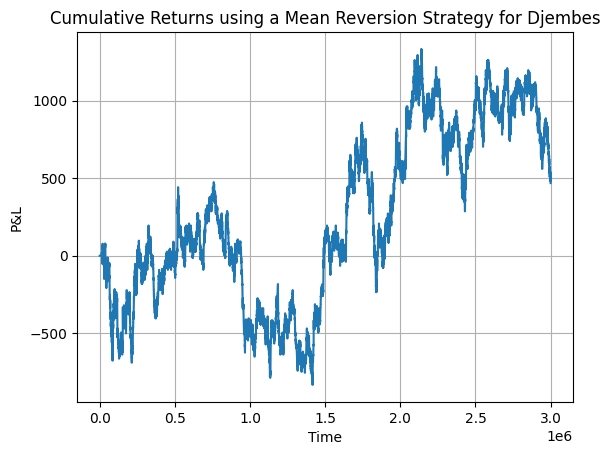

Sharpe Ratio: 0.001431891300737229


In [15]:
# Parameters for our Mean Reversion
# Includes a volatility filter, stop-loss, and dynamically changing order volume using z-scores
lookback = 100
z_position_cutoff = 2.5
z_neutral_cutoff = 0.2
min_volatility = 1
max_volatility = 10
entry_price = None
stop_loss_threshold = 5.1
min_volume = 1
max_volume = 15
scaling_factor = 5

# Rolling stats
djembes = df_concat[df_concat['product'] == 'DJEMBES']
djembes['sma'] = djembes['mid_price'].rolling(window=lookback).mean()
djembes['std'] = djembes['mid_price'].rolling(window=lookback).std()
djembes['z_score'] = (djembes['mid_price'] - djembes['sma']) / djembes['std']
djembes['z_buy'] = (djembes['bid_price_1'] - djembes['sma']) / djembes['std']
djembes['z_sell'] = (djembes['ask_price_1'] - djembes['sma']) / djembes['std']


# Initialize state
position = 0
positions = []
signals = []

for i in range(len(djembes)):
    z = djembes['z_score'].iloc[i]
    z_buy = djembes['z_buy'].iloc[i]
    z_sell = djembes['z_sell'].iloc[i]
    std = djembes['std'].iloc[i]

    signal = 0  # default no signal

    if np.isnan(z):  # skip if not enough data
        positions.append(0)
        signals.append(0)
        continue

    # Initializing volume numbers
    z_abs = abs(z)
    trade_volume = min(max_volume, int(z_abs * scaling_factor))
    trade_volume = max(min_volume, trade_volume)
    available_buying_volume = djembes['ask_volume_1'].iloc[i]
    available_selling_volume = djembes['bid_volume_1'].iloc[i]


    # ENTRY logic
    if z_buy > z_position_cutoff and position == 0 and std < max_volatility and std > min_volatility:
        trade_volume = min(available_selling_volume, trade_volume)
        signal = -1 * trade_volume
        position = -1 * trade_volume  # go short
        entry_price = djembes['bid_price_1'].iloc[i]
    elif z_sell < -z_position_cutoff and position == 0 and std < max_volatility and std > min_volatility:
        trade_volume = min(available_buying_volume, trade_volume)
        signal = trade_volume
        position = trade_volume  # go long
        entry_price = djembes['ask_price_1'].iloc[i] # Someone is selling and we are buying it

    # EXIT logic
    elif entry_price is not None and (z_sell < z_neutral_cutoff or djembes['ask_price_1'].iloc[i] > entry_price + stop_loss_threshold) and (position == -1):
        signal = 0
        position = 0  # exit short
        entry_price = None
    elif entry_price is not None and (z_buy > -z_neutral_cutoff or djembes['bid_price_1'].iloc[i] < entry_price - stop_loss_threshold) and position == 1:
        signal = 0
        position = 0  # exit long
        entry_price = None

    positions.append(position)
    signals.append(signal)

# Store results
djembes["position"] = positions
djembes["signal"] = signals
djembes["price_change"] = djembes["mid_price"].diff()
djembes["strategy_returns"] = djembes["position"].shift() * djembes["price_change"]
djembes["cumulative_returns"] = djembes["strategy_returns"].cumsum()
djembes["drawdown"] = (djembes["cumulative_returns"] - djembes["cumulative_returns"].cummax()).cummin

# Plot
plt.plot(djembes['timestamp'], djembes["cumulative_returns"])
plt.title("Cumulative Returns using a Mean Reversion Strategy for Djembes")
plt.xlabel("Time")
plt.ylabel("P&L")
plt.grid(True)
plt.show()

mean_return = djembes["strategy_returns"].mean()
std_return = djembes["strategy_returns"].std()

sharpe_ratio = mean_return / std_return
print(f"Sharpe Ratio: {sharpe_ratio}")